## Get pytorch official pretrained resnet 18 model

In [31]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image
from flopth import flopth
import matplotlib.pyplot as plt

In [ ]:
# Load the pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

In [33]:
# Use input size
flops, params = flopth(
    model, 
    in_size=((3, 224, 224),), 
    show_detail=True, 
    bare_number=True)
# print(flops, params)

+-----------------------+-------------------+--------------+--------------+------------------------------+----------+------------------+----------------------+----------+-----------------+---------------------+
| module_name           | module_type       | in_shape     | out_shape    | kernel_size,padding,stride   | params   | params_percent   | params_percent_vis   | flops    | flops_percent   | flops_percent_vis   |
+=======================+===================+==============+==============+==============================+==========+==================+======================+==========+=================+=====================+
| conv1                 | Conv2d            | (3,224,224)  | (64,112,112) | k=(7, 7), p=(3, 3), s=(2, 2) | 9.408K   | 0.0804824%       |                      | 118.014M | 6.47921%        | ###                 |
+-----------------------+-------------------+--------------+--------------+------------------------------+----------+------------------+--------------------

## resnet 18 architecture overview 
resnet18 consists of three types of layers:
- convolution layer 
- batch normalization layer 
- fully connected layer

Let's break down each layer and count the number of parameters and flops 


- parameters: weight and bias. Weights are numerical values assigned to the connections between neurons. Biases are additional parameters associated with neuron. 
$$
y = wx + b 
$$
- flops: 
- macs: 

### convolutional neural network 

$$
paramters = (k_w*k_h*C_{in} + 1) * C_{out}
$$

where: 
- $k_h $ = height of the convolutional kernel (filter)
- $k_w $ = width of the convolutional kernel (filter)
- $C_{in} $ = number of input channels (depth of the input)
- $C_{out} $ = number of output channels (number of filters)
- $ +1 $ = accounts for the bias term associated with each filter



$$
FLOPs = C_{out} * H_{out} * W_{out} * (C_{in}*k_w*k_h)

$$


In [38]:

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the convolutional layer parameters
C_in = 3      # Input channels
C_out = 64    # Output channels (filters)
kernel_size = (7, 7)
padding = (3, 3)
stride = (2, 2)

# Define the convolutional layer
conv_layer = nn.Conv2d(
    in_channels=C_in,
    out_channels=C_out,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding, 
    bias=False
)

input_tensor = torch.rand(1, C_in, 224, 224)
print('input: ', input_tensor[0, 0, 0:5, 0:5], 'shape: ', input_tensor.shape)

output_tensor = conv_layer(input_tensor)
print('output: ', output_tensor[0, 0, 0:5, 0:5], 'shape: ', output_tensor.shape)

print('num of weights by pytorch:', torch.numel(conv_layer.weight))
print('num of weights by hand:', (7*7*3 + 0)*64)


# Calculate output dimensions
H_in, W_in = input_tensor.shape[2], input_tensor.shape[3]
H_out = (H_in + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
W_out = (W_in + 2 * padding[1] - kernel_size[1]) // stride[1] + 1

# Calculate FLOPs
flops = C_out * H_out * W_out * (C_in * kernel_size[0] * kernel_size[1])
print("Conv2d FLOPs:", flops)  

input:  tensor([[0.2773, 0.8030, 0.0812, 0.1416, 0.9764],
        [0.7557, 0.6816, 0.8240, 0.5632, 0.3770],
        [0.4397, 0.3000, 0.3173, 0.7704, 0.4852],
        [0.1263, 0.6099, 0.4795, 0.0489, 0.1580],
        [0.6596, 0.4571, 0.6624, 0.0075, 0.1580]]) shape:  torch.Size([1, 3, 224, 224])
output:  tensor([[-0.4455, -0.2814, -0.1571, -0.1442, -0.2880],
        [-0.5149, -0.3853, -0.1012, -0.3554, -0.4398],
        [-0.6750, -0.5433, -0.5382, -0.5030, -0.4644],
        [-0.6450, -0.5626, -0.6828, -0.5469, -0.5461],
        [-0.7899, -0.7338, -0.4347, -0.5968, -0.5015]],
       grad_fn=<SliceBackward0>) shape:  torch.Size([1, 64, 112, 112])
num of weights by pytorch: 9408
num of weights by hand: 9408
Conv2d FLOPs: 118013952


In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print('params of conv2d w/o bias: ', count_parameters(conv_layer))

params of conv2d w/o bias:  9408


In [ ]:
# Use input size
flops, params = flopth(
    conv_layer, 
    in_size=((3, 224, 224),), 
    show_detail=True, 
    bare_number=True)
# print(flops, params)

# Or use input tensors
# dummy_inputs = torch.rand(1, 3, 224, 224)
# flops, params = flopth(conv_layer, inputs=(dummy_inputs,))
# print(flops, params)

### Batch Normalization 

normalize the data to address the problem of **internal covariate shift**, which occurs when the distribution of inputs to a layer changes during training, making it harder for the model to converge efficiently

- during training


step 1: calculate mean and variance per channel across batches
$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad \sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$$
where \( m \) is the batch size and \( x_i \) are the activations from the previous layer.

step 2: Normalization
$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

- step 3: Scale and Shift (weight/bias, gemma/beta)  
$$
y_i = \gamma \hat{x}_i + \beta
$$

- step 4: update running statistics  
$running\_mean = (1-momentum)*running\_mean + momentum* \mu$
$running\_var = (1-momentum)*running\_var + momentum* \sigma^2$



- During inference

$$
y_i = \gamma \left( \frac{x_i - \mu_{\text{running\_mean}}}{\sqrt{running\_var + \epsilon}} \right) + \beta
$$

- parameters  
Total Parameters=2×C  
where $C$ is channels

- FLOPs  
$O(4*N*C)$


In [44]:
import numpy as np

class BatchNorm2D:
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        
        # Initialize learnable parameters if affine is True
        if self.affine:
            self.gamma = np.ones(num_features)  # Scale
            self.beta = np.zeros(num_features)   # Shift
        else:
            self.gamma = None
            self.beta = None
        
        # Initialize running mean and variance
        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)
        
    def forward(self, x, training=True):
        # x has shape (batch_size, channels, height, width)
        if training:
            # Compute mean and variance for each channel
            batch_mean = np.mean(x, axis=(0, 2, 3))  # Mean over batch, height and width
            batch_var = np.var(x, axis=(0, 2, 3))    # Variance over batch, height and width
            print(f'batch mean: {batch_mean}, batch var: {batch_var}')

            # Normalize the input
            x_normalized = (x - batch_mean[:, None, None]) / np.sqrt(batch_var[:, None, None] + self.eps)

            # Update running mean and variance
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            print(f'running_mean: {self.running_mean}, running_var: {self.running_var}')

        else:
            # Use running statistics for inference
            x_normalized = (x - self.running_mean[:, None, None]) / np.sqrt(self.running_var[:, None, None] + self.eps)

        # Apply scale and shift if affine is True
        if self.affine:
            out = self.gamma[:, None, None] * x_normalized + self.beta[:, None, None]
        else:
            out = x_normalized
            
        return out

In [45]:

# Create a random input tensor with shape (batch_size, channels, height, width)
batch_size = 4
channels = 3  # For RGB images
height = 56
width = 56

# Simulate a mini-batch of images (e.g., 4 images of size 56x56 with 3 channels)
# Set random seed for reproducibility
np.random.seed(42)
input_tensor = np.random.rand(batch_size, channels, height, width)
print('input: ', input_tensor[0, 0, 0:5, 0:5])

# Create a BatchNorm2D layer for the number of channels
batch_norm_layer = BatchNorm2D(num_features=channels)

# Forward pass during training
output_train = batch_norm_layer.forward(input_tensor, training=True)
print("Output shape during training:", output_train.shape)

# Forward pass during inference
output_infer = batch_norm_layer.forward(input_tensor, training=False)
print("Output shape during inference:", output_infer.shape)

input:  [[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
 [0.0884925  0.19598286 0.04522729 0.32533033 0.38867729]
 [0.92969765 0.80812038 0.63340376 0.87146059 0.80367208]
 [0.04077514 0.59089294 0.67756436 0.01658783 0.51209306]
 [0.26520237 0.24398964 0.97301055 0.39309772 0.89204656]]
batch mean: [0.50022893 0.50005455 0.4984411 ], batch var: [0.08405608 0.08300136 0.08190397]
running_mean: [0.05002289 0.05000545 0.04984411], running_var: [0.90840561 0.90830014 0.9081904 ]
Output shape during training: (4, 3, 56, 56)
Output shape during inference: (4, 3, 56, 56)


- Fully connnected layer

- Max pooling 

Pixel at (0, 0): (108, 117, 64)
Pixel at (1, 0): (106, 115, 60)
Pixel at (2, 0): (108, 115, 61)
Pixel at (3, 0): (105, 113, 54)
Pixel at (4, 0): (108, 114, 52)
Pixel at (5, 0): (112, 119, 52)
Pixel at (6, 0): (111, 120, 53)
Pixel at (7, 0): (112, 123, 55)
Pixel at (8, 0): (110, 120, 57)
Pixel at (9, 0): (108, 119, 61)
Pixel at (10, 0): (112, 124, 78)
Pixel at (11, 0): (117, 128, 88)
Pixel at (12, 0): (114, 123, 92)
Pixel at (13, 0): (114, 123, 94)
Pixel at (14, 0): (117, 123, 97)
Pixel at (15, 0): (113, 119, 91)
Pixel at (16, 0): (112, 118, 90)
Pixel at (17, 0): (116, 123, 90)
Pixel at (18, 0): (128, 134, 96)
Pixel at (19, 0): (139, 146, 102)


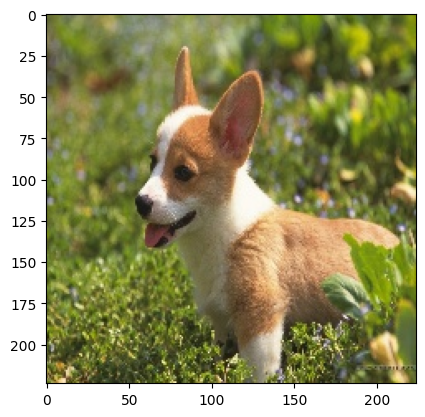

In [55]:
image = Image.open("../../data/dog.jpg")
width, height = image.size


# Prepare the image
transform = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for y in range(1):
    for x in range(20):
        pixel = image.getpixel((x, y))
        print(f"Pixel at ({x}, {y}): {pixel}")

plt.imshow(image)

In [58]:
transform1 = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform1(image).unsqueeze(0)
print('input shape: ', input_tensor.shape)   # h, w
print('input: ', input_tensor[0, :, 0, 0:20])  

input shape:  torch.Size([1, 3, 224, 224])
input:  tensor([[0.4235, 0.4157, 0.4235, 0.4118, 0.4235, 0.4392, 0.4353, 0.4392, 0.4314,
         0.4235, 0.4392, 0.4588, 0.4471, 0.4471, 0.4588, 0.4431, 0.4392, 0.4549,
         0.5020, 0.5451],
        [0.4588, 0.4510, 0.4510, 0.4431, 0.4471, 0.4667, 0.4706, 0.4824, 0.4706,
         0.4667, 0.4863, 0.5020, 0.4824, 0.4824, 0.4824, 0.4667, 0.4627, 0.4824,
         0.5255, 0.5725],
        [0.2510, 0.2353, 0.2392, 0.2118, 0.2039, 0.2039, 0.2078, 0.2157, 0.2235,
         0.2392, 0.3059, 0.3451, 0.3608, 0.3686, 0.3804, 0.3569, 0.3529, 0.3529,
         0.3765, 0.4000]])


In [63]:
(((108/ 255)-0.485)/0.229, ((117/ 255)-0.456)/0.224, ((64/ 255)- 0.406)/0.225) 

(-0.26843051631132797, 0.012605042016806558, -0.6889760348583879)

In [56]:
input_tensor = transform(image).unsqueeze(0)
print('input shape: ', input_tensor.shape)   # h, w
print('input: ', input_tensor[0, :, 0, 0:20])  

input shape:  torch.Size([1, 3, 224, 224])
input:  tensor([[-0.2684, -0.3027, -0.2684, -0.3198, -0.2684, -0.1999, -0.2171, -0.1999,
         -0.2342, -0.2684, -0.1999, -0.1143, -0.1657, -0.1657, -0.1143, -0.1828,
         -0.1999, -0.1314,  0.0741,  0.2624],
        [ 0.0126, -0.0224, -0.0224, -0.0574, -0.0399,  0.0476,  0.0651,  0.1176,
          0.0651,  0.0476,  0.1352,  0.2052,  0.1176,  0.1176,  0.1176,  0.0476,
          0.0301,  0.1176,  0.3102,  0.5203],
        [-0.6890, -0.7587, -0.7413, -0.8633, -0.8981, -0.8981, -0.8807, -0.8458,
         -0.8110, -0.7413, -0.4450, -0.2707, -0.2010, -0.1661, -0.1138, -0.2184,
         -0.2358, -0.2358, -0.1312, -0.0267]])


In [19]:
def inference_layer_by_layer(model, input_tensor):
    # Initialize a list to store output shapes
    output_shapes = []
    
    # Pass through the initial layers manually
    x = model.conv1(input_tensor)  # First convolutional layer
    x = model.bn1(x)               # Batch normalization
    x = model.relu(x)              # ReLU activation
    output_shapes.append(x.shape)

    x = model.maxpool(x)           # Max pooling
    output_shapes.append(x.shape)

    # Pass through each layer in the model's layers
    for layer in model.layer1:
        identity = x  # Save the input for the skip connection
        x = layer(x)  # Forward pass through the block
        output_shapes.append(x.shape)

    for layer in model.layer2:
        identity = x  # Save the input for the skip connection
        x = layer(x)  # Forward pass through the block
        output_shapes.append(x.shape)

    for layer in model.layer3:
        identity = x  # Save the input for the skip connection
        x = layer(x)  # Forward pass through the block
        output_shapes.append(x.shape)

    for layer in model.layer4:
        identity = x  # Save the input for the skip connection
        x = layer(x)  # Forward pass through the block
        output_shapes.append(x.shape)

    x = model.avgpool(x)            # Average pooling
    output_shapes.append(x.shape)

    x = torch.flatten(x, 1)         # Flattening for fully connected layer
    output_shapes.append(x.shape)

    x = model.fc(x)                 # Fully connected layer (final classification)
    output_shapes.append(x.shape)

    return output_shapes, x

In [20]:
# Perform inference and get output shapes after each layer
output_shapes, output = inference_layer_by_layer(model, input_tensor)

# Print output shapes after each layer
for i, shape in enumerate(output_shapes):
    print(f"Output shape after layer {i}: {shape}")

print('final output: ', output)

Output shape after layer 0: torch.Size([1, 64, 112, 112])
Output shape after layer 1: torch.Size([1, 64, 56, 56])
Output shape after layer 2: torch.Size([1, 64, 56, 56])
Output shape after layer 3: torch.Size([1, 64, 56, 56])
Output shape after layer 4: torch.Size([1, 128, 28, 28])
Output shape after layer 5: torch.Size([1, 128, 28, 28])
Output shape after layer 6: torch.Size([1, 256, 14, 14])
Output shape after layer 7: torch.Size([1, 256, 14, 14])
Output shape after layer 8: torch.Size([1, 512, 7, 7])
Output shape after layer 9: torch.Size([1, 512, 7, 7])
Output shape after layer 10: torch.Size([1, 512, 1, 1])
Output shape after layer 11: torch.Size([1, 512])
Output shape after layer 12: torch.Size([1, 1000])
final output:  tensor([[-1.2039e+00,  4.2362e-01, -9.8585e-01, -3.1726e+00,  2.5497e-01,
          1.2354e+00, -2.3235e+00,  1.2684e+00,  1.3664e+00, -3.3360e+00,
         -1.0839e+00, -1.5226e+00, -1.8018e+00, -1.0200e+00, -3.1366e+00,
         -3.9797e-01,  3.1790e-01,  2.3645

In [30]:
logits = output
softmax_output = F.softmax(logits, dim=1)

# Get the index of the maximum value in the softmax output
max_index = torch.argmax(softmax_output, dim=1)

# print("Logits:\n", logits)
# print("Softmax Output:\n", softmax_output)
print("Index of Maximum Probability:", max_index.item())
print("Maximum Probability:", softmax_output[0, max_index.item()])


Index of Maximum Probability: 263
Maximum Probability: tensor(0.5262, grad_fn=<SelectBackward0>)
